In [55]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
df_full = pd.read_csv("processed-data/processed_2023_qc.csv")
df_full["date"] = pd.to_datetime(df_full["date"])

## Checking the quality of data

***QC test categories:***

G - Good


F - Too many minutely flags failed QC


M - Missing too many time-steps

In [57]:
df_qc = df_full.loc[:, ["date", "time"] + df_full.columns[df_full.columns.str.startswith("qcscore")].tolist()]
qc_list = [col for col in df_qc.columns if col not in ["date", "time"]]
(df_qc[qc_list].apply(pd.Series.value_counts).fillna(0)
                                             .astype(int)
                                             .sort_values(by="qcscore", ascending=False))

,qcscore,qcscore_maxt,qcscore_mint,qcscore_rh,qcscore_ws,qcscore_wd,qcscore_60rf,qcscore_sol
G,8755,8760,8760,8760,8760,5556,8759,8709
F,5,0,0,0,0,0,0,51
M,0,0,0,0,0,3025,1,0


In [58]:
df = df_full[["date", 
              "time", 
              "Air Temperature in degree C", 
              "Minimum Air Temperature in degree C", 
              "Maximum Air Temperature in degree C",
              "Relative Humidity in %",
              "Wind Speed in km/hr",
              "Wind Direction", 
              "Past 60-Minutes Rainfall in mm", 
              "Solar Radiation in W/m^2"]]

df = df.rename(columns={"Air Temperature in degree C": "temp(c)",
                        "Minimum Air Temperature in degree C": "min_temp(c)",
                        "Maximum Air Temperature in degree C": "max_temp(c)",
                        "Relative Humidity in %": "rel_humid(%)",
                        "Wind Speed in km/hr": "wind_speed(km/hr)",
                        "Wind Direction": "wind_dir",
                        "Past 60-Minutes Rainfall in mm": "rainfall(mm)",
                        "Solar Radiation in W/m^2": "sol_rad(W/m^2)"})

df["hour"] = np.arange(df.shape[0])

df.head(5)

,date,time,temp(c),min_temp(c),max_temp(c),rel_humid(%),wind_speed(km/hr),wind_dir,rainfall(mm),sol_rad(W/m^2),hour
0,2023-01-01,00:00:00,16.0,12.3,19.8,76.5,2.9,9.8,0.0,0.0,0
1,2023-01-01,01:00:00,16.0,16.0,16.1,76.8,3.1,12.2,0.0,0.0,1
2,2023-01-01,02:00:00,15.7,15.7,16.1,76.6,3.8,11.1,0.0,0.0,2
3,2023-01-01,03:00:00,15.2,15.2,16.1,78.5,3.3,8.5,0.0,0.0,3
4,2023-01-01,04:00:00,15.0,15.0,16.1,79.5,3.7,12.6,0.0,0.0,4


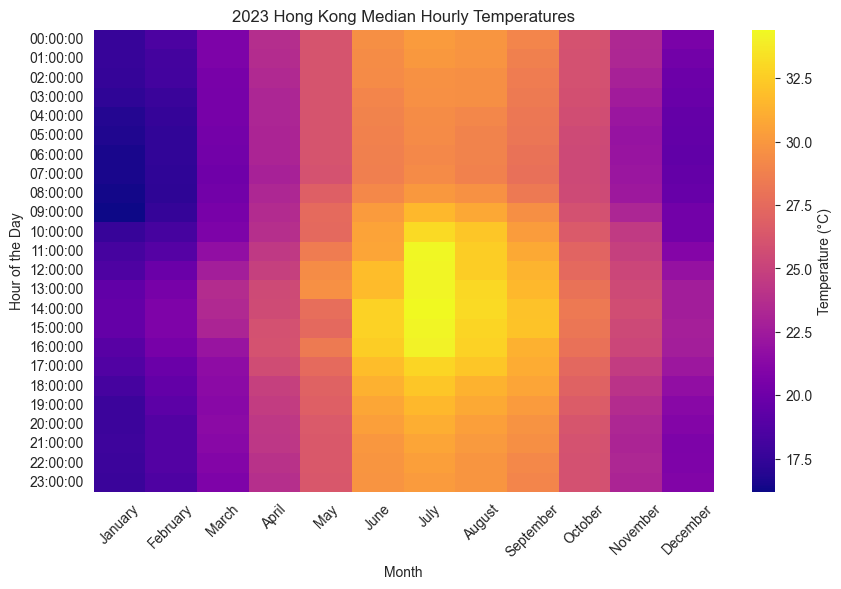

In [59]:
# Plot a heatmap of the median hourly temperature distribution across the whole year
df_temp = df[["date", "time", "temp(c)"]].copy()
df_temp["month"] = df["date"].dt.strftime("%B")
df_temp["month_num"] = df["date"].dt.month
df_temp = df_temp.drop(columns={"date"})
df_avg_hr_temp_year = (df_temp.groupby(["time", "month"])
                              .aggregate("median")
                              .sort_values(by=["month_num", "time"])
                              .reset_index())

month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]

df_avg_hr_temp_year["month"] = pd.Categorical(df_avg_hr_temp_year["month"], 
                                              categories=month_order, 
                                              ordered=True)

heatmap_data = df_avg_hr_temp_year.pivot(index="time", 
                                         columns="month", 
                                         values="temp(c)")

# Plot the heatmap
plt.figure(figsize=(10, 6))

sns.heatmap(heatmap_data, 
            annot=False, 
            cmap="plasma", 
            cbar_kws={"label": "Temperature (°C)"})

plt.xticks(rotation=45)
plt.title("2023 Hong Kong Median Hourly Temperatures")
plt.ylabel("Hour of the Day")
plt.xlabel("Month")
plt.savefig("output-graphs/hourly_year_temp.png")
plt.show()

# Weekly Analysis

Extracting data from the week of the 2nd Monday of January and July to represent Winter and Summer weather in Hong Kong.

In [60]:
df_jan_week = df[(df["date"] >= "2023-01-09") & (df["date"] < "2023-01-16")].copy()
df_july_week = df[(df["date"] >= "2023-07-10") & (df["date"] < "2023-07-17")].copy()

In [61]:
df_july_week

,date,time,temp(c),min_temp(c),max_temp(c),rel_humid(%),wind_speed(km/hr),wind_dir,rainfall(mm),sol_rad(W/m^2),hour
4560,2023-07-10,00:00:00,30.2,29.2,35.6,94.1,0.1,5.0,0.0,0.0,4560
4561,2023-07-10,01:00:00,30.0,30.0,30.2,95.0,0.1,5.0,0.0,0.0,4561
4562,2023-07-10,02:00:00,29.8,29.8,30.2,95.6,0.1,5.0,0.0,0.0,4562
4563,2023-07-10,03:00:00,29.7,29.7,30.2,95.6,0.0,5.0,0.0,0.0,4563
4564,2023-07-10,04:00:00,29.6,29.6,30.2,96.0,0.1,5.0,0.0,0.0,4564
...,...,...,...,...,...,...,...,...,...,...,...
4723,2023-07-16,19:00:00,29.7,27.6,33.0,88.5,8.9,6.8,0.0,27.0,4723
4724,2023-07-16,20:00:00,28.7,27.6,33.0,92.3,6.0,5.8,0.0,0.0,4724
4725,2023-07-16,21:00:00,28.6,27.6,33.0,90.8,7.6,6.3,0.0,0.0,4725
4726,2023-07-16,22:00:00,28.3,27.6,33.0,93.1,5.3,6.5,0.0,0.0,4726


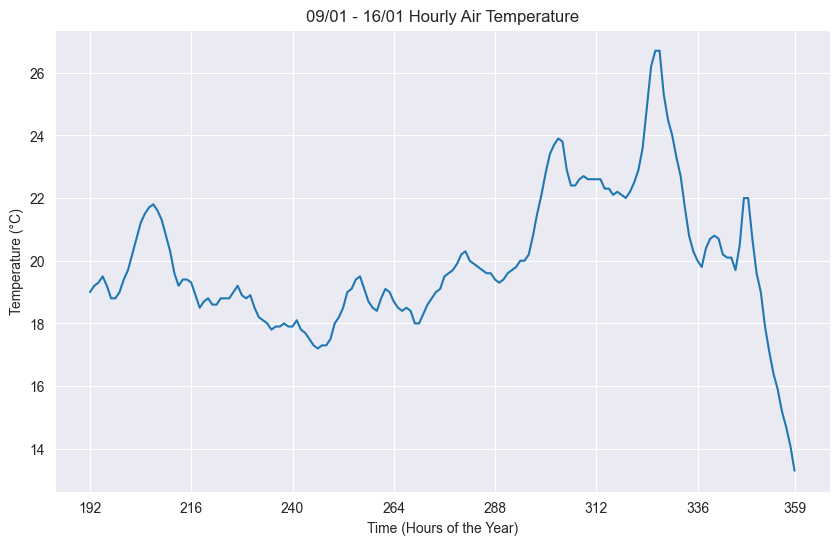

In [62]:
plt.figure(figsize=(10, 6))

sns.lineplot(x="hour", y="temp(c)", data=df_jan_week)
plt.title("09/01 - 16/01 Hourly Air Temperature")
plt.ylabel("Temperature (°C)")
plt.xlabel("Time (Hours of the Year)")
plt.xticks(list(df_jan_week["hour"][::24]) + [df_jan_week["hour"].iloc[-1]])
plt.show()

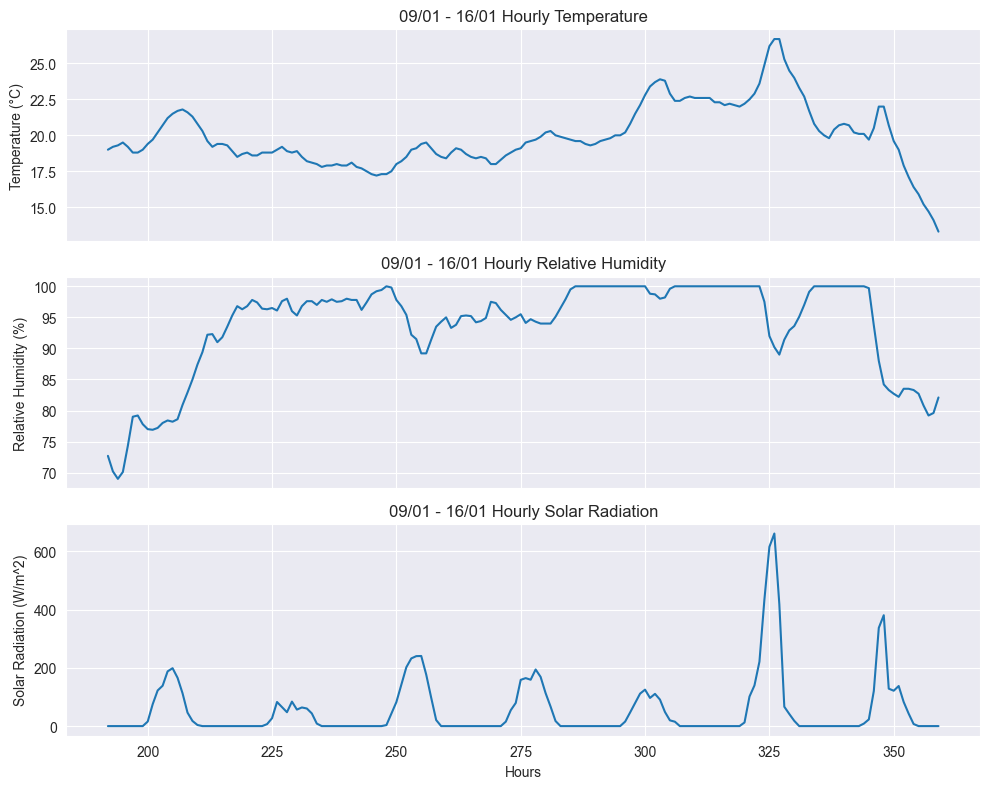

In [65]:
cols_plot = {"temp(c)": "Temperature (°C)", 
             "rel_humid(%)": "Relative Humidity (%)", 
             "sol_rad(W/m^2)": "Solar Radiation (W/m^2)"}

fig, axes = plt.subplots(len(cols_plot), 1, figsize=(10, 8), sharex=True)

# Loop through each column and plot on a separate subplot
for i, (key, value) in enumerate(cols_plot.items()):
    cleaned_label = re.sub(r"\s*\(.*?\)", "", value)
    sns.lineplot(x="hour", y=key, data=df_jan_week, ax=axes[i])
    axes[i].set_title(f"09/01 - 16/01 Hourly {cleaned_label}")
    axes[i].set_ylabel(value)

# Set common x-axis label
axes[-1].set_xlabel("Hours")

plt.tight_layout()  # Adjust layout
plt.show()                                 

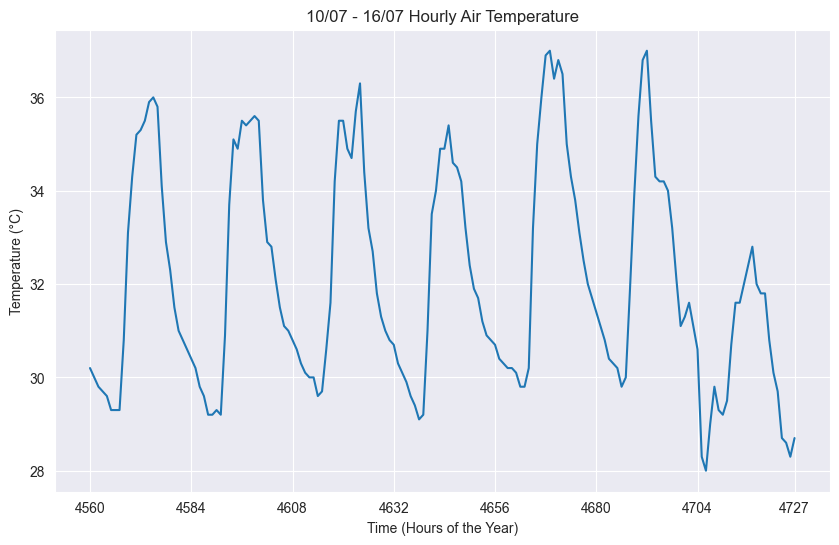

In [64]:
plt.figure(figsize=(10, 6))

sns.lineplot(x="hour", y="temp(c)", data=df_july_week)
plt.title("10/07 - 16/07 Hourly Air Temperature")
plt.ylabel("Temperature (°C)")
plt.xlabel("Time (Hours of the Year)")
plt.xticks(list(df_july_week["hour"][::24]) + [df_july_week["hour"].iloc[-1]])
plt.show()

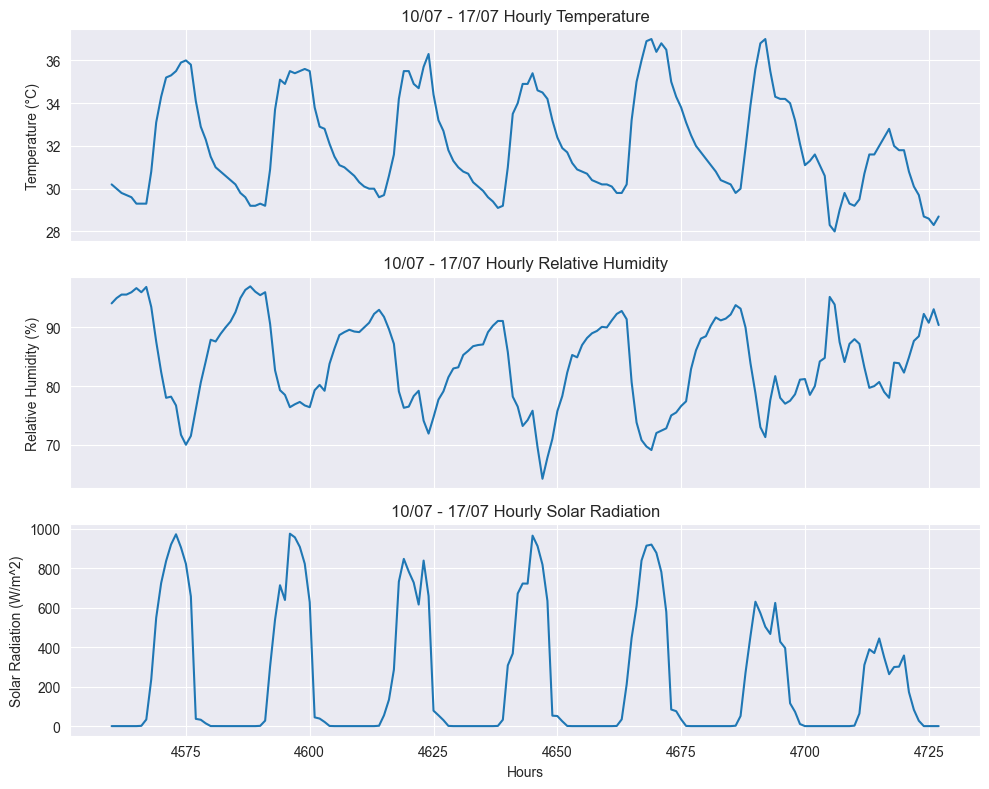

In [67]:
cols_plot = {"temp(c)": "Temperature (°C)", 
             "rel_humid(%)": "Relative Humidity (%)", 
             "sol_rad(W/m^2)": "Solar Radiation (W/m^2)"}

fig, axes = plt.subplots(len(cols_plot), 1, figsize=(10, 8), sharex=True)

# Loop through each column and plot on a separate subplot
for i, (key, value) in enumerate(cols_plot.items()):
    cleaned_label = re.sub(r"\s*\(.*?\)", "", value)
    sns.lineplot(x="hour", y=key, data=df_july_week, ax=axes[i])
    axes[i].set_title(f"10/07 - 17/07 Hourly {cleaned_label}")
    axes[i].set_ylabel(value)

# Set common x-axis label
axes[-1].set_xlabel("Hours")

plt.tight_layout()  # Adjust layout
plt.show()